In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
#inspect the tables
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
print('---------------')   
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [52]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date


('2017-08-23',)

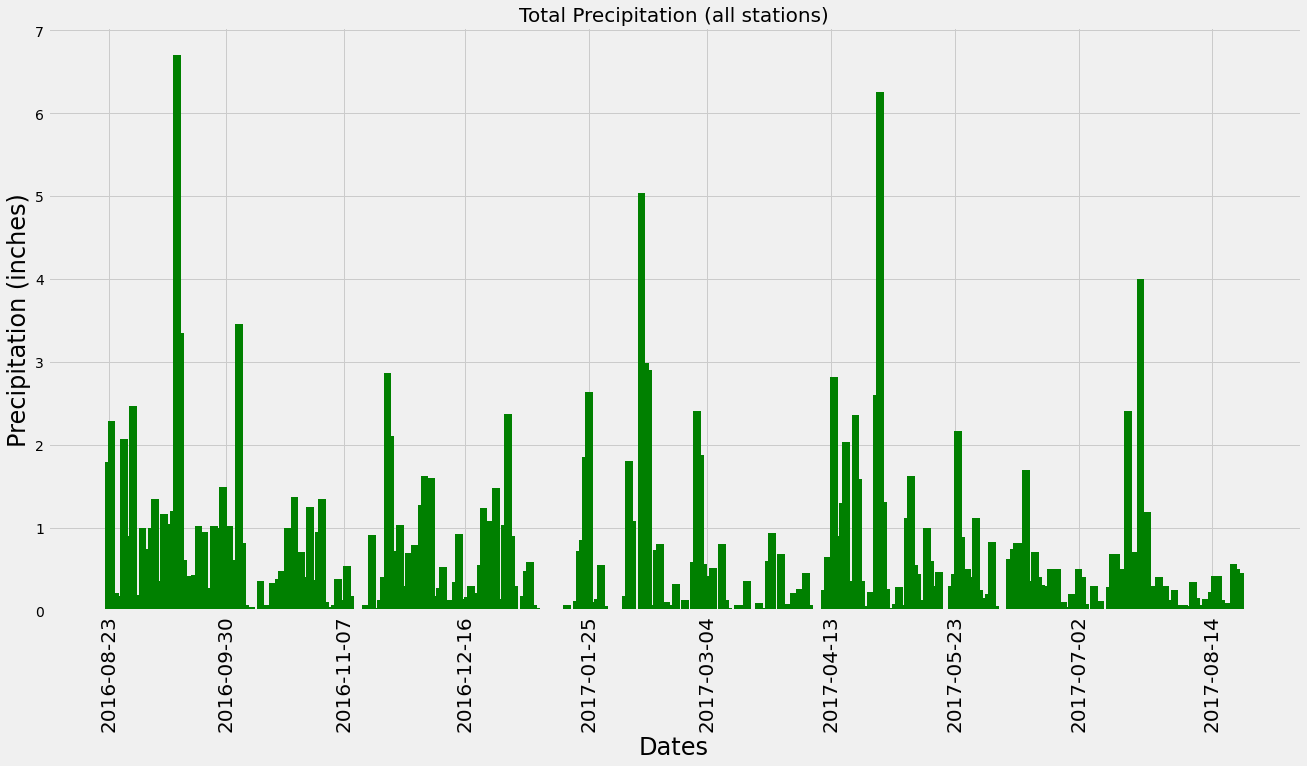

In [187]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date, Measurement.prcp]
precip_data = session.query(*sel).\
filter(Measurement.date >= (year_ago)).order_by(Measurement.date).all()

#group_by(func.strftime("%m", Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(precip_data, columns = ['Date','Precipitation']).dropna()
# Sort the dataframe by date
df_sort = df.set_index('Date')

# Use Pandas Plotting with Matplotlib to plot the data

plt.subplots(figsize=(20, 10))
xaxis = df['Date']
yaxis = df['Precipitation']

plt.bar(xaxis,yaxis,color='g', width = 2.5, alpha=1)

plt.title('Total Precipitation (all stations)',fontsize=20 )
plt.xlabel('Dates',fontsize=24)
plt.ylabel('Precipitation (inches)',fontsize=24)

plt.xticks(xaxis,rotation='vertical',fontsize=20)
plt.locator_params(axis='x', nbins=len(xaxis)/220)  
plt.show()


In [174]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_sort.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [188]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [212]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
#session.query(Measurement.station, Measurement.date).group_by(Measurement.station).all()

sel = [Measurement.station, func.count(Measurement.station)]
count_stations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
#Station with the highest number of rows
count_stations



('USC00519281', 2772)

In [246]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
act_station = 'USC00519281'
sel = [Measurement.station, Measurement.tobs, Station.name]
sel2 = [Measurement.station, func.avg(Measurement.tobs)]
#temp_stations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

lowest_temp = session.query(*sel).\
filter(Measurement.station == act_station).order_by(Measurement.tobs).first()
highest_temp = session.query(*sel).\
filter(Measurement.station == act_station).order_by(Measurement.tobs.desc()).first()

avg_temp = session.query(*sel2).\
filter(Measurement.station == act_station).order_by(Measurement.tobs.desc()).first()

print(f'The lowest, highest and averagre temperature for station {act_station},{lowest_temp[2]} are \
{lowest_temp[1]}, {highest_temp[1]} and {round(avg_temp[1],2)} respectively.')

The lowest, highest and averagre temperature for station USC00519281,WAIKIKI 717.2, HI US are 54.0, 85.0 and 71.66 respectively.


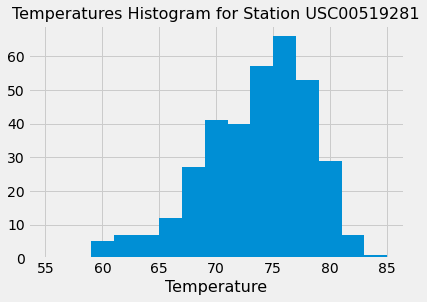

In [249]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date one year from the last date in data set.
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

sel = [Measurement.station, Measurement.date, Measurement.tobs]
temp= session.query(*sel).\
filter(Measurement.date >= (last_year)).\
filter(Measurement.station == act_station).\
order_by(Measurement.date).all()

temp_hist = [temperature[2] for temperature in temp]
plt.hist(temp_hist, bins=15, range=(55, 85))
plt.title(f'Temperatures Histogram for Station {act_station}',fontsize=16)
plt.xlabel('Temperature',fontsize=16)
plt.show()


# Close session

In [247]:
# Close Session
session.close()